# Ejecutable de seguimiento de la opinión pública usando MCMC:
## Elecciones presidenciales 2021

Alonso Rojas, Tiare Letelier

## Primera vuelta

In [1]:
# Se importan las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import dirichlet, gamma

### Datos:

In [2]:
# Se guarda el documento Excel a utilizar, contiene los datos de las elecciones.
# En particular, se usa la hoja llamada "Datos_por_dia" del Excel "Datosfinal".
df = pd.read_excel('Datosfinal.xlsx', sheet_name='Datos_por_dia')

# Se guardan los datos de 2021 desde la fila 189 hacia adelante,
# lo cual es desde el 13 de agosto de 2021 hasta el 21 de noviembre de 2021.
# Además, se guardan solamente los votos para los candidatos más populares:
# Jose Antonio Kast, Sebastian Sichel, Gabriel Boric y Yasna Provoste.
datos2021 = df.to_numpy()[189:, 3:]
datos2021 = np.array(datos2021, dtype=int)

### Modelo 1:
Distribución de prueba: $Gamma(500\times\alpha_{ti}+y_{ti}, 1)$

In [3]:
# Se define el modelo para analizar los datos, basado en la distribución Gamma y la distribución Dirichlet.
# Recibe como parámetros los datos "data" y la cantidad de iteraciones "N".
def modelo1(data, N):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha)
    prueba = lambda alpha: np.array([gamma.rvs(a) for a in alpha])
    # Cantidad de días.
    days = np.size(data, 0)
    # Cantidad de candidatos.
    cand = np.size(data, 1)
    # Va a guardar las muestras generadas.
    muestra = np.zeros((N, days, cand))
    # Probabilidad a priori uniforme para cada candidato.
    prior = np.full(cand, 1/cand)
    c = np.zeros(days)
    for i in range(N):
        for day in range(days):
            if day == 0:
                p = prior 
            else:
                p = muestra[i, day-1]
            # Observaciones del día actual
            y = data[day]
            # Cálculo alpha
            alpha = y + 500 * p
            p_prueba = prueba(alpha)
            p_prueba = p_prueba / p_prueba.sum()
            # Metropolis-Hasting
            metrop = post(p_prueba, alpha) - post(p, alpha)
            if min(metrop, 0) > np.log(np.random.uniform()):
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p
    # Muestra generada y cantidad de aceptaciones por día.
    return muestra, c

In [4]:
# Parámetros a cambiar.
datos1 = datos2021
iteraciones1 = 1000

aceptados dia 1: 100.000000%
aceptados dia 2: 37.200000%
aceptados dia 3: 33.800000%
aceptados dia 4: 37.800000%
aceptados dia 5: 33.800000%
aceptados dia 6: 37.800000%
aceptados dia 7: 36.600000%
aceptados dia 8: 36.500000%
aceptados dia 9: 38.200000%
aceptados dia 10: 35.100000%
aceptados dia 11: 36.700000%
aceptados dia 12: 34.600000%
aceptados dia 13: 36.400000%
aceptados dia 14: 33.200000%
aceptados dia 15: 100.000000%
aceptados dia 16: 100.000000%
aceptados dia 17: 97.600000%
aceptados dia 18: 36.100000%
aceptados dia 19: 94.300000%
aceptados dia 20: 34.400000%
aceptados dia 21: 36.400000%
aceptados dia 22: 94.200000%
aceptados dia 23: 33.300000%
aceptados dia 24: 33.700000%
aceptados dia 25: 35.600000%
aceptados dia 26: 71.300000%
aceptados dia 27: 35.900000%
aceptados dia 28: 38.400000%
aceptados dia 29: 35.500000%
aceptados dia 30: 73.300000%
aceptados dia 31: 71.600000%
aceptados dia 32: 36.600000%
aceptados dia 33: 38.000000%
aceptados dia 34: 37.000000%
aceptados dia 35: 35

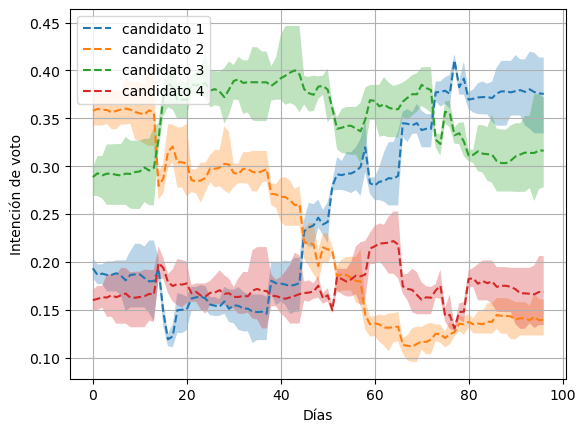

In [5]:
muestra1, c1 = modelo1(datos1, iteraciones1)
# Se reduce la muestra a un submuestreo.
muestra1 = muestra1[iteraciones1//10::100]

# Calcula el promedio para cada día del submuestreo.
prop = muestra1.mean(0)
# Se guarda como variable la cantidad de días.
days = np.size(prop, 0)
# Intervalos de credibilidad 90%.
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra1, q, axis=0)
# Se plotea el porcentaje de aceptación por cada día.
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c1[i]/iteraciones1))
    
# Se grafica el porcentaje de aceptación por cada día y el intervalo de confianza.
for i in range(4):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [6]:
# Se usa el último día de la lista de los promedios.
pred = prop[-1]
# Se muestra el porcentaje estimado para cada candidato.
print('Kast: {:%}'.format(pred[0]))
print('Sichel: {:%}'.format(pred[1]))
print('Boric: {:%}'.format(pred[2]))
print('Provoste: {:%}'.format(pred[3]))

Kast: 37.551239%
Sichel: 13.978475%
Boric: 31.617330%
Provoste: 16.852956%


### Modelo 2:
Distribución de prueba: $Unif(\max\{(500\alpha_{t-1,i}+y_{ti})-d,0\},(500\alpha_{t-1,i}+y_{ti})+d)$
(discreta)

In [7]:
# Se define el segundo modelo para analizar los datos, basado en la distribución uniforme y la distribución Dirichlet.
# Recibe como parámetros los datos "data", la cantidad de iteraciones "N" y  rango alrededor del valor esperado "d".
def modelo2(data, N, d):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha)
    # Cantidad de días.
    days = np.size(data, axis=0)
    # Cantidad de candidatos.
    cand = np.size(data, axis=1)
    prueba = lambda alpha, d: np.random.randint(np.maximum(alpha-d,0),alpha+d, size=cand)
    # Va a guardar las muestras generadas.
    muestra = np.zeros((N, days, cand))
    # Probabilidad a priori uniforme para cada candidato.
    prior = np.full(cand, 1/cand)
    c = np.zeros(days)
    for i in range(N):
        for day in range(days):
            if day == 0:
                p = prior
            else:
                p = muestra[i, day-1]
            # Observaciones del día actual
            y = data[day]
            # Cálculo alpha
            alpha = 500 * p + y
            p_prueba = prueba(alpha, d)
            p_prueba = p_prueba/p_prueba.sum()
            if post(p_prueba, alpha) - post(p, alpha) > np.log(np.random.uniform()):
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p
    # Muestra generada y cantidad de aceptaciones por día.
    return muestra, c

In [8]:
# Parámetros a cambiar.
datos2 = datos2021
iteraciones2 = 10_000
d = 50

aceptados dia 1: 100.000000%
aceptados dia 2: 2.680000%
aceptados dia 3: 2.770000%
aceptados dia 4: 2.540000%
aceptados dia 5: 2.670000%
aceptados dia 6: 2.850000%
aceptados dia 7: 3.010000%
aceptados dia 8: 2.470000%
aceptados dia 9: 2.490000%
aceptados dia 10: 2.400000%
aceptados dia 11: 2.880000%
aceptados dia 12: 2.590000%
aceptados dia 13: 2.710000%
aceptados dia 14: 2.610000%
aceptados dia 15: 100.000000%
aceptados dia 16: 99.680000%
aceptados dia 17: 41.770000%
aceptados dia 18: 2.330000%
aceptados dia 19: 31.490000%
aceptados dia 20: 2.450000%
aceptados dia 21: 2.680000%
aceptados dia 22: 79.810000%
aceptados dia 23: 2.540000%
aceptados dia 24: 2.310000%
aceptados dia 25: 2.340000%
aceptados dia 26: 14.180000%
aceptados dia 27: 2.390000%
aceptados dia 28: 2.420000%
aceptados dia 29: 2.180000%
aceptados dia 30: 19.200000%
aceptados dia 31: 18.110000%
aceptados dia 32: 2.490000%
aceptados dia 33: 2.320000%
aceptados dia 34: 2.060000%
aceptados dia 35: 2.210000%
aceptados dia 36: 

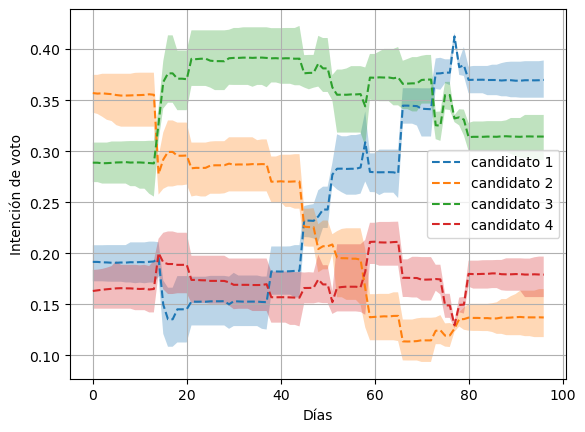

In [9]:
muestra2, c2 = modelo2(datos2, iteraciones2, d)
# Se reduce la muestra a un submuestreo.
muestra2 = muestra2[iteraciones2//10::100]

# Calcula el promedio para cada día del submuestreo.
prop = muestra2.mean(0)
# Se guarda como variable la cantidad de días.
days = np.size(prop, 0)
# Intervalos de credibilidad 90%.
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra2, q, axis=0)
# Se plotea el porcentaje de aceptación por cada día.
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c2[i]/iteraciones2))
    
# Se grafica el porcentaje de aceptación por cada día y el intervalo de confianza.
for i in range(4):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [10]:
# Se usa el último día de la lista de los promedios.
pred = prop[-1]
# Se muestra el porcentaje estimado para cada candidato.
print('Kast: {:%}'.format(pred[0]))
print('Sichel: {:%}'.format(pred[1]))
print('Boric: {:%}'.format(pred[2]))
print('Provoste: {:%}'.format(pred[3]))

Kast: 36.980996%
Sichel: 13.697981%
Boric: 31.425569%
Provoste: 17.895454%
